In [1]:
%cd ComputerVisionProject/

/home/group.kurse/cviwo012/ComputerVisionProject


/home/group.kurse/cviwo012/my-env/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Clustering

In [2]:
import torch
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt

from CellDataset import CellDataset
from MoCoResNetBackbone import MoCoResNetBackbone

In [3]:
os.listdir("/scratch/cv-course-group-5/models/training3/")

['model_epoch10.pth',
 'loss_epoch10.pth',
 'loss_epoch15.pth',
 'loss_epoch20.pth',
 'model_epoch20.pth',
 'model_epoch5.pth',
 'loss_epoch5.pth',
 'model_epoch15.pth']

In [4]:
# ========== Configuration ==========
checkpoint_path = Path("/scratch/cv-course-group-5/models/training2/model_epoch45.pth")  # adjust if needed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64
# save_path = Path("embeddings_cells.npz")

In [5]:
_json_path = Path('train_test_split.json')

# Load the file
with open(_json_path, 'r') as f:
    _split_data = json.load(f)

# Access the train and test entries
train_list = _split_data.get("train", [])
test_list = _split_data.get("test", [])
val_list = _split_data.get("val", [])

In [6]:
# ========== Load model ==========
model = MoCoResNetBackbone()
model.to(device)

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint)
model.eval()

# ========== Prepare dataset ==========
dataset = CellDataset(video_list=val_list[:10], mode='inference')
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

53453


# Create Embeddings

In [7]:
all_embeddings = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(dataloader, desc="Extracting embeddings"):
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.cpu().numpy()  # optional, if tensor
        embeddings = model.encode_query(imgs)  # → (B, 2048)
        embeddings = embeddings.cpu().numpy()

        all_embeddings.append(embeddings)
        all_labels.append(labels)

Extracting embeddings: 100%|██████████████| 836/836 [00:36<00:00, 22.79it/s]


In [8]:
embeddings = np.concatenate(all_embeddings, axis=0)
labels = np.concatenate(all_labels, axis=0)

In [9]:
# Get unique values and their counts
values, counts = np.unique(labels, return_counts=True)

# Compute percentages
percentages = counts / counts.sum() * 100

# Print results
for val, pct in zip(values, percentages):
    print(f"Value {val}: {pct:.2f}%")

Value 0: 4.99%
Value 1: 95.01%


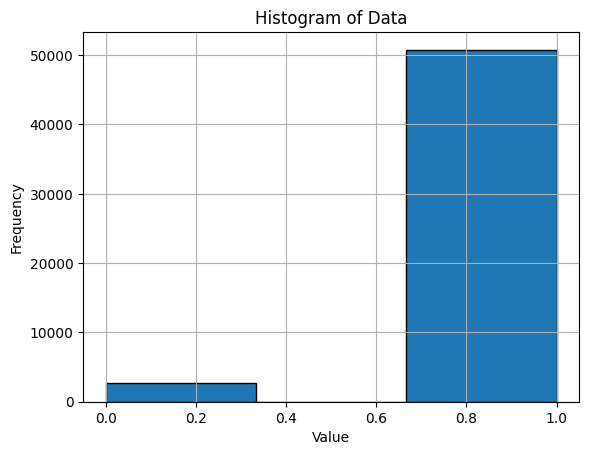

In [10]:
plt.hist(labels, bins=3, edgecolor='black')
plt.title("Histogram of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# PCA

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [12]:
# 1. Fit PCA with 10 components
pca = PCA(n_components=5)
X_pca = pca.fit_transform(embeddings)

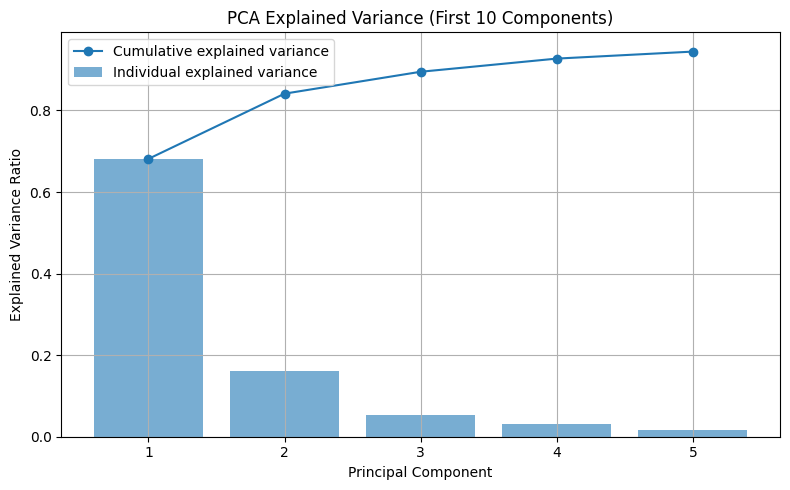

In [13]:
# 2. Explained variance ratio
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# 3. Plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_var)+1), explained_var, alpha=0.6, label='Individual explained variance')
plt.plot(range(1, len(cumulative_var)+1), cumulative_var, marker='o', label='Cumulative explained variance')
plt.xticks(range(1, len(cumulative_var)+1))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance (First 10 Components)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Clustering

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering, HDBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)

In [15]:
clusterers = {
    "HDBSCAN": HDBSCAN(min_cluster_size=50),
    "GMM": GaussianMixture(n_components=2, covariance_type='full', random_state=42, weights_init=[0.96, 0.04]),
    "Agglomerative": AgglomerativeClustering(n_clusters=2, linkage='complete')
}

# === Step 3: Evaluation functions ===
def evaluate_unsupervised(X, labels_pred):
    if len(set(labels_pred)) > 1:
        sil = silhouette_score(X, labels_pred)
        db = davies_bouldin_score(X, labels_pred)
    else:
        sil, db = np.nan, np.nan
    return sil, db

def evaluate_supervised(y_true, y_pred):
    ari = adjusted_rand_score(y_true, y_pred)
    nmi = normalized_mutual_info_score(y_true, y_pred)
    return ari, nmi

In [16]:
# === Step 4: Run clustering and evaluate ===
results = []

for name, model in clusterers.items():
    labels_pred = model.fit_predict(X_pca)
    
    sil, db = evaluate_unsupervised(X_pca, labels_pred)
    ari, nmi = evaluate_supervised(labels, labels_pred)
    n_clusters = len(set(labels_pred)) - (1 if -1 in labels_pred else 0)
    
    results.append({
        "Method": name,
        "#Clusters": n_clusters,
        "Silhouette": sil,
        "Davies-Bouldin": db,
        "ARI": ari,
        "NMI": nmi
    })

In [17]:

# === Step 5: Print results table ===
print("\n=== Clustering Evaluation Summary ===")
print(f"{'Method':<15} {'#Clusters':<10} {'Silhouette':<12} {'DB Index':<10} {'ARI':<8} {'NMI':<8}")
print("-" * 65)
for r in results:
    print(f"{r['Method']:<15} {r['#Clusters']:<10} "
          f"{r['Silhouette']:<12.3f} {r['Davies-Bouldin']:<10.3f} "
          f"{r['ARI']:<8.3f} {r['NMI']:<8.3f}")


=== Clustering Evaluation Summary ===
Method          #Clusters  Silhouette   DB Index   ARI      NMI     
-----------------------------------------------------------------
HDBSCAN         2          0.695        1.179      0.022    0.002   
GMM             2          0.525        1.151      0.023    0.002   
Agglomerative   2          0.923        0.310      -0.003   0.001   
